In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from feature_engineering import *

In [3]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [4]:
sns.set(font='Lato', font_scale=1.5)

In [5]:
def predict_profit(X, profit, clf, bins=20):
    """
    Estimate total profit as a percentage of the population called.
    
    """
    predicted_df = pd.DataFrame()
    predicted_df['profit'] = profit
    predicted_df['proba'] = clf.predict_proba(X)[:, 1]
    predicted_df['bin_positive'] = pd.qcut(predicted_df['proba'], bins)
    binned_profit = []
    for bin_id, data in predicted_df.groupby('bin_positive'):
        binned_profit.append(data['profit'].sum())
    binned_profit.append(0)
    return predicted_df, np.array(binned_profit[::-1]).cumsum()

### Read features and target from file

In [6]:
feature_target_file = '../output/bank_all_features_target.csv'
feature_target_df = pd.read_csv(feature_target_file)
features_df, target = extract_features_target(feature_target_df)

### Add the net profit per customer

In [7]:
profit = target*features_df['balance']*0.01-1
features_df['profit'] = profit

## Train/test split, make sure split the profit column
Then extract the features and the profit separately

In [8]:
X_train_profit, X_test_profit, y_train, y_test = train_test_split(features_df.values, target, test_size=0.2, random_state=42)
X_train = X_train_profit[:, :-1]
X_test = X_test_profit[:, :-1]
profit_train = X_train_profit[:,-1]
profit_test = X_test_profit[:, -1]

## Build models
1. Logistic Regression
2. Random Forest
3. Gradient Boosting

In [10]:
lr_pipe = make_pipeline(StandardScaler(), LogisticRegression(C=10))
lr_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [11]:
forest = RandomForestClassifier(class_weight={0: 1, 1:10}, max_depth=10, max_features=50, n_estimators=300)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=10, max_features=50,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [35]:
gbrt = GradientBoostingClassifier(max_depth=5, n_estimators=200)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## Make prediction

In [13]:
base_case = profit_test.sum()
base_case

10855.38

In [14]:
bins = 20
ratios = 1./(bins)*np.arange(bins+1)*100
_, cum_profit_lr = predict_profit(X_test, profit_test, lr_pipe, bins=bins)
predicted_df, cum_profit_rf = predict_profit(X_test, profit_test, forest, bins=bins)
_, cum_profit_gbrt = predict_profit(X_test, profit_test, gbrt, bins=bins)

## Plot predicted profit versus customers called

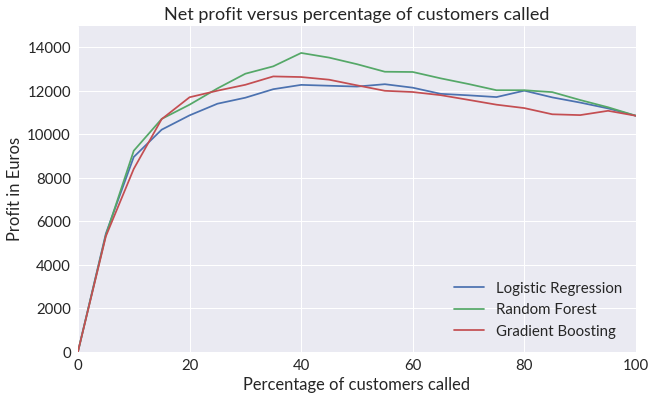

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(ratios, cum_profit_lr, label='Logistic Regression')
plt.plot(ratios, cum_profit_rf, label='Random Forest')
plt.plot(ratios, cum_profit_gbrt, label='Gradient Boosting')
plt.ylabel('Profit in Euros')
plt.xlabel('Percentage of customers called')
plt.xlim(0, 100)
plt.ylim(0, 15000)
plt.legend()
plt.title("Net profit versus percentage of customers called");

## Precision Recall tradeoff

The advantageous thing about random forests is the `class_weight` parameter. This allows different weights to be placed on the negative and positive class so that misclassfied points have different penalties. In this case since we are interested in reducing the number of false negatives, we can place a higher weight on the positive class, which results in a decrease in precision (more false positives) but increased revenue as shown in the figure. 

## Estimate maximum profit obtained

In [16]:
max_profit, ratio_called = np.max(cum_profit_rf), np.argmax(cum_profit_rf)*1./bins*100

In [17]:
print("Maximum profit {:.3f} reached when {:.1f} percent of customers contacted".format(max_profit, ratio_called))

Maximum profit 13743.580 reached when 40.0 percent of customers contacted


In [18]:
print("Expected profit for 10 million customers is {:.1f} million Euros".format(1.e7/len(profit_test)*max_profit/1.e6))

Expected profit for 10 million customers is 15.2 million Euros


In [36]:
print(classification_report(y_pred=forest.predict(X_train), y_true=y_train))
print(classification_report(y_pred=forest.predict(X_test), y_true=y_test))
print(cross_val_score(forest, X_train, y_train))

             precision    recall  f1-score   support

          0       0.90      0.99      0.95     31970
          1       0.80      0.17      0.28      4198

avg / total       0.89      0.90      0.87     36168

             precision    recall  f1-score   support

          0       0.90      0.99      0.94      7952
          1       0.73      0.16      0.27      1091

avg / total       0.88      0.89      0.86      9043

[0.89491582 0.89366291 0.89182912]


In [30]:
forest = RandomForestClassifier(class_weight={0: 1, 1:1}, max_depth=10, max_features=10, n_estimators=200)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
            criterion='gini', max_depth=10, max_features=10,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [32]:
print(cross_val_score(forest, X_train, y_train))
print(classification_report(y_pred=forest.predict(X_test), y_true=y_test))

[0.89400348 0.89366291 0.89207798]
             precision    recall  f1-score   support

          0       0.90      0.99      0.94      7952
          1       0.73      0.16      0.27      1091

avg / total       0.88      0.89      0.86      9043



In [37]:
print(classification_report(y_pred=gbrt.predict(X_train), y_true=y_train))
print(classification_report(y_pred=gbrt.predict(X_test), y_true=y_test))

             precision    recall  f1-score   support

          0       0.92      0.99      0.96     31970
          1       0.85      0.37      0.52      4198

avg / total       0.91      0.92      0.91     36168

             precision    recall  f1-score   support

          0       0.91      0.98      0.94      7952
          1       0.64      0.25      0.36      1091

avg / total       0.87      0.89      0.87      9043



In [33]:
print(cross_val_score(gbrt, X_train, y_train))

[0.88305549 0.8882714  0.88510991]


In [38]:
print(classification_report(y_pred=lr_pipe.predict(X_train), y_true=y_train))
print(classification_report(y_pred=lr_pipe.predict(X_test), y_true=y_test))

             precision    recall  f1-score   support

          0       0.90      0.99      0.94     31970
          1       0.63      0.19      0.29      4198

avg / total       0.87      0.89      0.87     36168

             precision    recall  f1-score   support

          0       0.90      0.99      0.94      7952
          1       0.64      0.19      0.30      1091

avg / total       0.87      0.89      0.86      9043



In [34]:
print(cross_val_score(lr_pipe, X_train, y_train))

[0.8923447  0.89374585 0.89091663]


In [28]:
from sklearn.model_selection import cross_val_score